# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [48]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [32]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("DataFrames Practice") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [33]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [34]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [35]:
df.filter(df['userId'] == '').count()

8346

In [36]:
df = df.filter(df['userId']!='')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [37]:
# Gender distribution
df.select('gender') \
    .groupBy('gender') \
    .agg({'gender':'count'}) \
    .withColumnRenamed('count(gender)', 'gender_count') \
    .sort(desc('gender_count')) \
    .show()

+------+------------+
|gender|gender_count|
+------+------------+
|     F|      154578|
|     M|      123576|
+------+------------+



In [38]:
# Location distribution
df.select('location') \
    .groupBy('location') \
    .agg({'location':'count'}) \
    .withColumnRenamed('count(location)', 'loc_count') \
    .sort(desc('loc_count')) \
    .show()

+--------------------+---------+
|            location|loc_count|
+--------------------+---------+
|Los Angeles-Long ...|    30131|
|New York-Newark-J...|    23684|
|Boston-Cambridge-...|    13873|
|Houston-The Woodl...|     9499|
|Charlotte-Concord...|     7780|
|Dallas-Fort Worth...|     7605|
|Louisville/Jeffer...|     6880|
|Philadelphia-Camd...|     5890|
|Chicago-Napervill...|     5114|
|    St. Louis, MO-IL|     4858|
|Phoenix-Mesa-Scot...|     4846|
|Vineland-Bridgeto...|     4825|
|          Wilson, NC|     4659|
|Denver-Aurora-Lak...|     4453|
|           Ionia, MI|     4428|
|San Antonio-New B...|     4373|
|        Danville, VA|     4257|
|Atlanta-Sandy Spr...|     4236|
|New Haven-Milford...|     4007|
|         Jackson, MS|     3839|
+--------------------+---------+
only showing top 20 rows



In [39]:
# Artist Popularity
df.filter(df.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show()

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
|      The Black Keys|       1125|
|                Muse|       1090|
|       Justin Bieber|       1044|
|        Jack Johnson|       1007|
|              Eminem|        953|
|           Radiohead|        884|
|     Alliance Ethnik|        876|
|               Train|        854|
|        Taylor Swift|        840|
|         OneRepublic|        828|
|         The Killers|        822|
|         Linkin Park|        787|
|         Evanescence|        781|
|            Harmonia|        729|
|       Guns N' Roses|        713|
+--------------------+-----------+
only showing top 20 rows



In [40]:
# Level distribution
df.select('level') \
    .groupBy('level') \
    .agg({'level':'count'}) \
    .withColumnRenamed('count(level)', 'lev_count') \
    .sort(desc('lev_count')) \
    .show()

+-----+---------+
|level|lev_count|
+-----+---------+
| paid|   222433|
| free|    55721|
+-----+---------+



In [41]:
# Registration distribution
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
df = df.withColumn("month", get_month(df.ts))

In [42]:
df.select('month') \
    .groupBy('month') \
    .agg({'month': 'count'}) \
    .withColumnRenamed('count(month)', 'reg_month_count') \
    .sort(desc('reg_month_count')) \
    .show()

+-----+---------------+
|month|reg_month_count|
+-----+---------------+
|   10|         144916|
|   11|         133234|
|   12|              4|
+-----+---------------+



**Define & Separate Churn from the Dataframe**

In [44]:
churn_record = df.filter((df['page']=='Cancellation Confirmation') | (df['page']=='Submit Downgrade')) \
                    .dropDuplicates(['userId'])

churn_users = churn_record.select('userId') \
                .rdd.flatMap(lambda x: x) \
                .collect()

df_churn = df.filter(df['userId'].isin(churn_users))
df_not_churn = df.filter(~df['userId'].isin(churn_users))

In [ ]:
cancel_record = df.filter(df['page']=='Cancellation Confirmation')

canceled_users = cancel_record.select('userId') \
                    .rdd.flatMap(lambda x: x) \
                    .collect()

df_cancel = df.filter(df['userId'].isin(canceled_users))

In [16]:
paid_users = df.filter(df['level']=='paid') \
                .select('userId') \
                .rdd.flatMap(lambda x: x) \
                .collect()

df_paid = df.filter(df['userId'].isin(paid_users))

**Visualization**

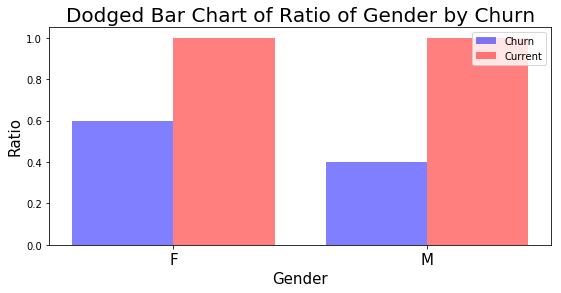

In [17]:
# Gender Ratio
churn_gender_pd = df_churn.groupBy('gender').count().toPandas()
not_churn_gender_pd = df_not_churn.groupBy('gender').count().toPandas().drop(1, axis=0)

not_churn_gender_pd['ratio'] = not_churn_gender_pd['count'] / not_churn_gender_pd['count'].sum()
churn_gender_pd['ratio'] = churn_gender_pd['count'] / churn_gender_pd['count'].sum()

label = churn_gender_pd['gender'].tolist()
index = np.arange(len(label))
bar_width = 0.4

plt.figure(figsize=(9, 4))

p1 = plt.bar(index, churn_gender_pd['ratio'],
             width = bar_width,
             color = 'blue',
             alpha = 0.5)

p2 = plt.bar(index + bar_width, not_churn_gender_pd['ratio'],
             width = bar_width,
             color = 'red',
             alpha = 0.5)

plt.title('Dodged Bar Chart of Ratio of Gender by Churn', fontsize=20)
plt.ylabel('Ratio', fontsize=15)
plt.xlabel('Gender', fontsize=15)
plt.xticks(index + bar_width/2, label, fontsize=15)
plt.legend((p1[0], p2[0]), ('Churn', 'Current'), loc='upper right', fontsize=10)


plt.show()

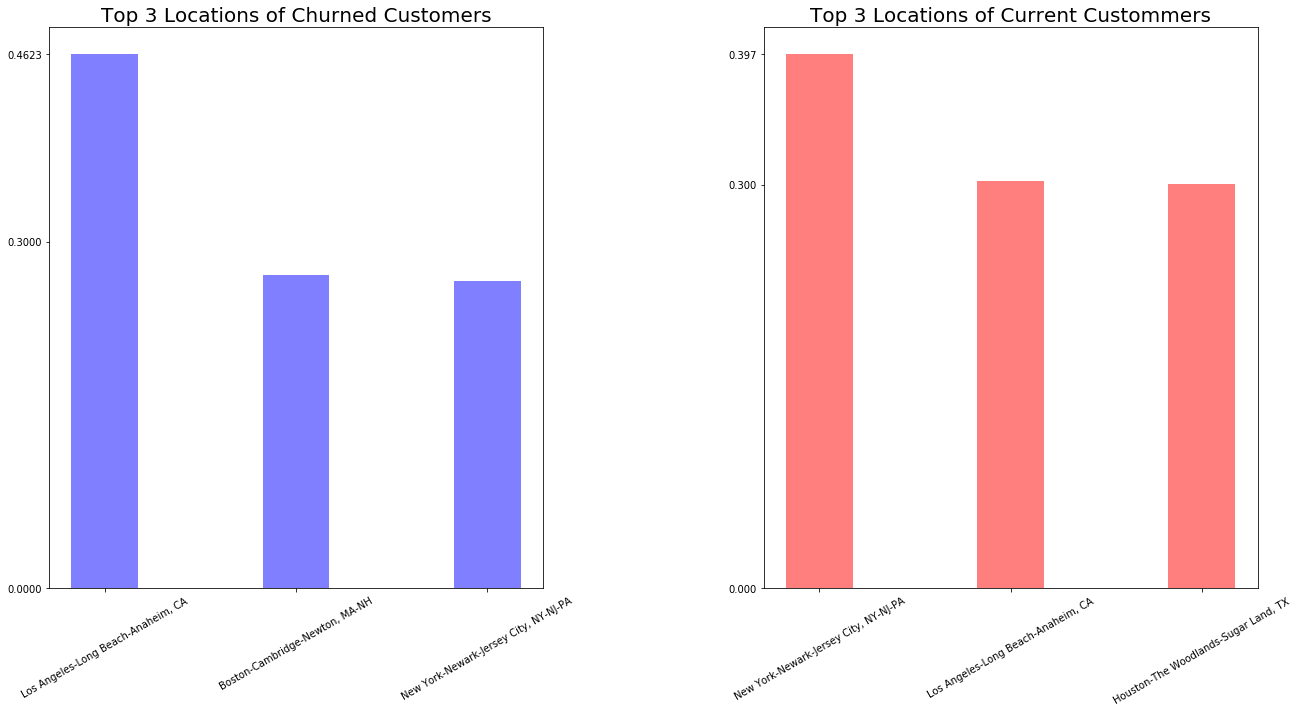

In [18]:
# Location Ratio
churn_loc_pd = df_churn.groupBy('location').count().toPandas()
not_churn_loc_pd = df_not_churn.groupBy('location').count().toPandas()

top3_loc_churn = churn_loc_pd.sort_values('count', ascending=False).head(3)
top3_loc_not_churn = not_churn_loc_pd.sort_values('count', ascending=False).head(3)

top3_loc_churn['ratio'] = top3_loc_churn['count'] / top3_loc_churn['count'].sum()
top3_loc_not_churn['ratio'] = top3_loc_not_churn['count'] / top3_loc_not_churn['count'].sum()

label_churn = top3_loc_churn['location'].tolist()
label_not_churn = top3_loc_not_churn['location'].tolist()

index_churn = np.arange(len(label_churn))
index_not_churn = np.arange(len(label_not_churn))

fig = plt.figure(figsize=(20, 10))

fig.subplots_adjust(wspace=4)

p1 = fig.add_subplot(1, 2, 1)
p2 = fig.add_subplot(1, 2, 2)

p1.bar(index_churn, top3_loc_churn['ratio'],
       width = 0.35,
       color = 'blue',
       alpha = 0.5)
p1.set_title("Top 3 Locations of Churned Customers", fontsize=20)
plt.setp(p1, xticks=index_churn, xticklabels=label_churn, yticks=[0, 0.3, max(top3_loc_churn['ratio'])])
p1.set_xticklabels(label_churn, rotation=30)

p2.bar(index_not_churn, top3_loc_not_churn['ratio'],
       width = 0.35,
       color = 'red',
       alpha = 0.5)
p2.set_title("Top 3 Locations of Current Custommers", fontsize=20)
plt.setp(p2, xticks=index_not_churn, xticklabels=label_not_churn, yticks=[0, 0.3, max(top3_loc_not_churn['ratio'])])
p2.set_xticklabels(label_not_churn, rotation=30)

plt.tight_layout()
plt.show()

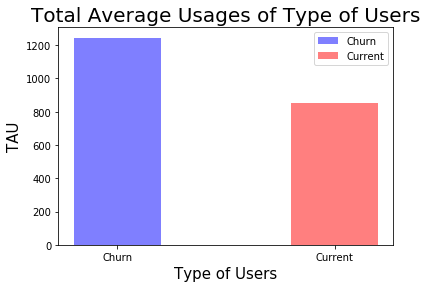

In [19]:
# User Behavior - Usage of Sparkify
churn_usage = df_churn.filter(df_churn.page == 'NextSong') \
                .select('userId') \
                .groupBy('userId') \
                .agg({'userId':'count'}) \
                .withColumnRenamed('count(userId)', 'usage_count') \
                .sort(desc('usage_count')) \
                .toPandas()

not_churn_usage = df_not_churn.filter(df_not_churn.page == 'NextSong') \
                    .select('userId') \
                    .groupBy('userId') \
                    .agg({'userId':'count'}) \
                    .withColumnRenamed('count(userId)', 'usage_count') \
                    .sort(desc('usage_count')) \
                    .toPandas()

churn_TAU = churn_usage.usage_count.sum() / churn_usage.userId.count()
current_TAU = not_churn_usage.usage_count.sum() / not_churn_usage.userId.count()
label = ['Churn', 'Current']
bar_width =0.4

plt.figure(figsize=(6, 4))
plot = plt.bar(label, [churn_TAU, current_TAU],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Total Average Usages of Type of Users', fontsize=20)
plt.ylabel('TAU', fontsize=15)
plt.xlabel('Type of Users', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Churn', 'Current'), loc='upper right', fontsize=10)

plt.show()

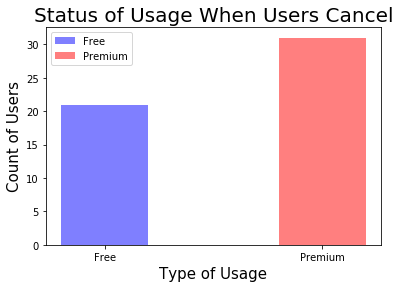

In [20]:
# Status of usage when users cancel sparkify service
fr_cancel_num = df_cancel.filter((df_cancel['page']=="Cancellation Confirmation") & (df_cancel['level']=="free")) \
                .select('userId') \
                .count()
pr_cancel_num = df_cancel.filter((df_cancel['page']=="Cancellation Confirmation") & (df_cancel['level']=="paid")) \
                .select('userId') \
                .count()

label = ['Free', 'Premium']
bar_width = 0.4

plt.figure(figsize=(6, 4))

plot = plt.bar(label, [fr_cancel_num, pr_cancel_num],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Status of Usage When Users Cancel', fontsize=20)
plt.ylabel('Count of Users', fontsize=15)
plt.xlabel('Type of Usage', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Free', 'Premium'), loc='upper left', fontsize=10)

plt.show()

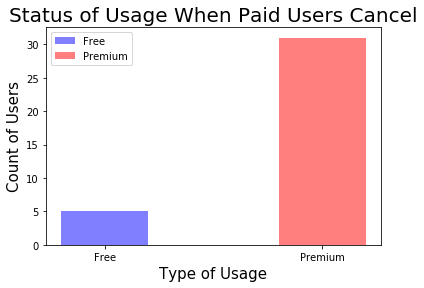

In [21]:
# Status of usage when paid users cancel sparkify service
fr_cancel_num = df_paid.filter((df_paid['page']=="Cancellation Confirmation") & (df_paid['level']=="free")) \
                .select('userId') \
                .count()
pr_cancel_num = df_paid.filter((df_paid['page']=="Cancellation Confirmation") & (df_paid['level']=="paid")) \
                .select('userId') \
                .count()

label = ['Free', 'Premium']
bar_width = 0.4

plt.figure(figsize=(6, 4))

plot = plt.bar(label, [fr_cancel_num, pr_cancel_num],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Status of Usage When Paid Users Cancel', fontsize=20)
plt.ylabel('Count of Users', fontsize=15)
plt.xlabel('Type of Usage', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Free', 'Premium'), loc='upper left', fontsize=10)

plt.show()

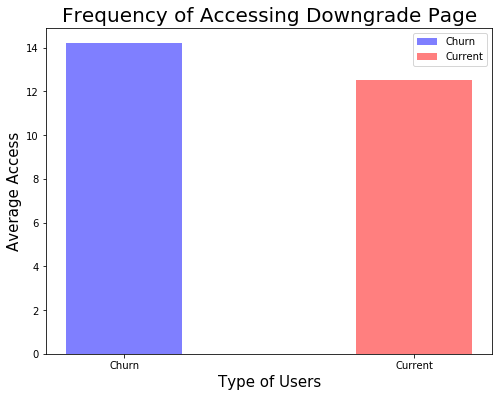

In [22]:
# The frequency of accessing Downgrade page
d_page_access_churn = df_churn.filter(df_churn['page']=='Downgrade') \
                        .select('userId') \
                        .groupBy('userId') \
                        .agg({'userId':'count'}) \
                        .withColumnRenamed('count(userId)', 'downgrade page access') \
                        .toPandas()
    
d_page_access_current = df_not_churn.filter(df_churn['page']=='Downgrade') \
                        .select('userId') \
                        .groupBy('userId') \
                        .agg({'userId':'count'}) \
                        .withColumnRenamed('count(userId)', 'downgrade page access') \
                        .toPandas()

d_frequency_churn = d_page_access_churn['downgrade page access'].sum() / d_page_access_churn.shape[0]
d_frequency_current = d_page_access_current['downgrade page access'].sum() / d_page_access_current.shape[0]

label = ['Churn', 'Current']
bar_width = 0.4

plt.figure(figsize=(8, 6))

plot = plt.bar(label, [d_frequency_churn, d_frequency_current],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Frequency of Accessing Downgrade Page', fontsize=20)
plt.ylabel('Average Access', fontsize=15)
plt.xlabel('Type of Users', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Churn', 'Current'), loc='upper right', fontsize=10)

plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [188]:
df_churn = df_churn.withColumn("churn", lit(1))
df_not_churn = df_not_churn.withColumn("churn", lit(0))

In [190]:
df = df_churn.union(df_not_churn).select('userId', 'gender', 'level', 'page', 'churn')

In [191]:
df_level_cnt = df.groupby('userId', 'level') \
                 .pivot('level', ['free', 'paid']) \
                 .count() \
                 .drop('level') \
                 .orderBy('userId')

In [192]:
df_page_cnt = df.filter((df['page']=='NextSong') | (df['page']=='Submit Downgrade') | (df['page']=='Submit Upgrade') | 
                        (df['page']=='Downgrade') | (df['page']=='Thumbs Up') | (df['page']=='Thumbs Down') | 
                        (df['page']=='Add to Playlist') | (df['page']=='Add Friend')) \
                .groupby('userId', 'page') \
                .pivot('page') \
                .count() \
                .drop('page') \
                .orderBy('userId')

In [193]:
df = df.drop('level', 'page') \
       .join(df_level_cnt, 'userId', 'inner') \
       .join(df_page_cnt, 'userId', 'inner') \
       .orderBy('userId') \
       .dropDuplicates()

In [194]:
df = df.groupby('userId', 'gender').max()

In [204]:
features = df.select(['gender', 'max(free)', 'max(paid)', 'max(Add Friend)',
                      'max(Add to Playlist)', 'max(Downgrade)', 'max(NextSong)',
                      'max(Submit Downgrade)', 'max(Submit Upgrade)', 'max(Thumbs Down)', 'max(Thumbs Up)']) \
             .withColumnRenamed('max(free)', 'free') \
             .withColumnRenamed('max(paid)', 'paid') \
             .withColumnRenamed('max(Add Friend)', 'add_friend') \
             .withColumnRenamed('max(Add to Playlist)', 'add_playlist') \
             .withColumnRenamed('max(Downgrade)', 'd_pge_access') \
             .withColumnRenamed('max(NextSong)', 'num_music') \
             .withColumnRenamed('max(Submit Downgrade)', 'num_downgrade') \
             .withColumnRenamed('max(Submit Upgrade)', 'num_upgrade') \
             .withColumnRenamed('max(Thumbs Down)', 'dislike') \
             .withColumnRenamed('max(Thumbs Up)', 'like') \
             .fillna(0)

In [206]:
churn = df.select('max(churn)') \
          .withColumnRenamed('max(churn)', 'churn')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.